Solving for T = 0.155 GeV, αₛ = 0.3000
Solving for T = 0.163 GeV, αₛ = 0.3000
Solving for T = 0.170 GeV, αₛ = 0.3000
Solving for T = 0.178 GeV, αₛ = 0.2952
Solving for T = 0.186 GeV, αₛ = 0.2890
Solving for T = 0.193 GeV, αₛ = 0.2833
Solving for T = 0.201 GeV, αₛ = 0.2780
Solving for T = 0.208 GeV, αₛ = 0.2731
Solving for T = 0.216 GeV, αₛ = 0.2686
Solving for T = 0.224 GeV, αₛ = 0.2644
Solving for T = 0.231 GeV, αₛ = 0.2605
Solving for T = 0.239 GeV, αₛ = 0.2568
Solving for T = 0.247 GeV, αₛ = 0.2533
Solving for T = 0.254 GeV, αₛ = 0.2501
Solving for T = 0.262 GeV, αₛ = 0.2470
Solving for T = 0.269 GeV, αₛ = 0.2441
Solving for T = 0.277 GeV, αₛ = 0.2413
Solving for T = 0.285 GeV, αₛ = 0.2387
Solving for T = 0.292 GeV, αₛ = 0.2362
Solving for T = 0.300 GeV, αₛ = 0.2338


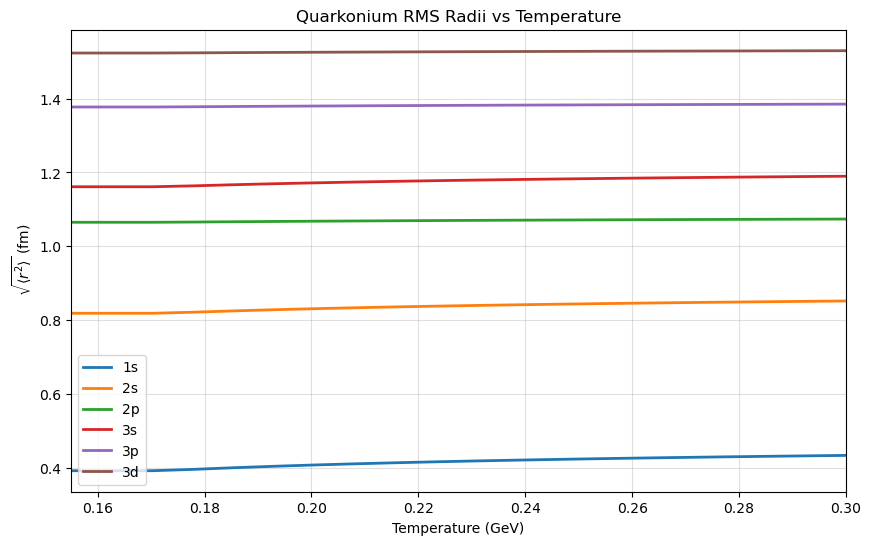

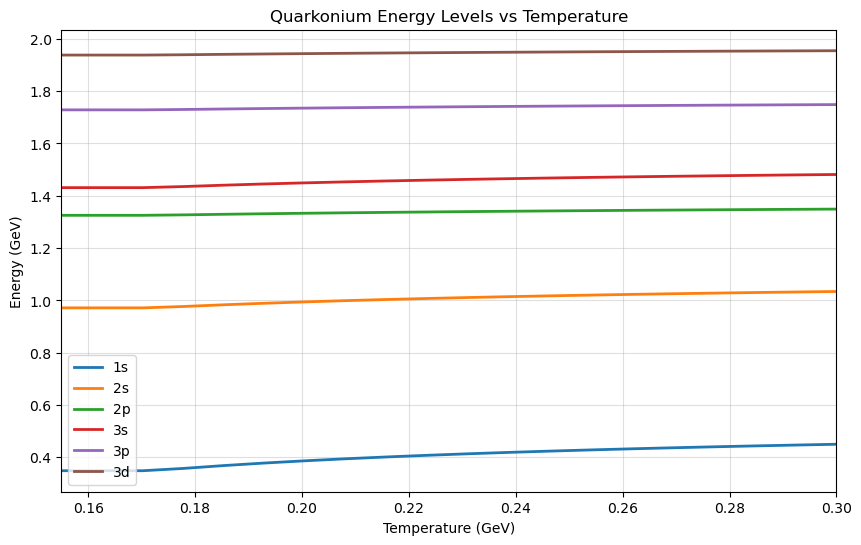

All results saved in directory: /Users/mohammadyousuf/Desktop/ML_QQ_codes/ML_code_QQ/quarkonia_thermal_results


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# Constants
hbar = 0.19732  # GeV·fm
sigma = 0.184   # GeV^2
xmin, xmax = 0.001, 30.0  # Range in fm
interval = 2001  # Resolution
Nf = 3  # Number of active flavors
Lambda_QCD = 0.176  # Scale (GeV)

# Create output directory
output_dir = "quarkonia_thermal_results"
os.makedirs(output_dir, exist_ok=True)

# Temperature range (GeV)
T_min = 0.155  # Just above critical temperature
T_max = 0.300  # Up to 500 MeV
T_points = 20
temperatures = np.linspace(T_min, T_max, T_points)

# Running coupling calculation
def g2inv(T):

    mu = 2 * np.pi
    beta0 = (11 - 2 / 3 * Nf) / (16 * np.pi**2)
    beta1 = (102 - 38 / 3 * Nf) / (16 * np.pi**2)**2

    log_term = np.log((mu * T) /Lambda_QCD)
    return 2 * beta0 * log_term + (beta1 / beta0) * np.log(2 * log_term)

def alpha_s(T):
    if T <= Lambda_QCD:
        return 0.3  # Frozen below Lambda_QCD
    """Running coupling alpha(T)"""
    return 1 / (4 * np.pi * g2inv(T))


# # Two-loop running coupling
# def alpha_s(T):
#     """Calculate two-loop running coupling"""
#     if T <= Lambda_QCD:
#         return 0.3  # Frozen below Lambda_QCD
    
#     logT = math.log(T**2/Lambda_QCD**2)
#     loglogT = math.log(logT)
    
#     numerator = 12 * math.pi * ((33 - 2*Nf)**2 * logT + 6*(-153 + 19*Nf)*loglogT)
#     denominator = (33 - 2*Nf)**3 * logT**2
    
#     return numerator / denominator

# Schrodinger solver class (modified for temperature dependence)
class QuarkoniumSolver:
    def __init__(self, mass, hbar, xmin, xmax, ninterval):
        self.r = np.linspace(xmin, xmax, ninterval)
        self.dr = self.r[1] - self.r[0]
        self.mass = mass
        self.hbar = hbar
        
    def solve_state(self, n, l, alpha_s, sigma):
        """Solve for a specific state with given parameters"""
        # Cornell potential with current alpha_s
        def potential(r):
            r_reg = np.where(r < 0.001, 0.001, r)
            s = r_reg / 0.197  # Convert to GeV^-1
            return -4/3 * alpha_s / s + sigma * s
            
        # Effective potential
        centrifugal = l*(l+1)*self.hbar**2/(2*self.mass*self.r**2)
        U = np.diag(potential(self.r) + centrifugal, 0)
        Lap = self.laplacian(len(self.r))
        H = -self.hbar**2/(2.0*self.mass)*Lap + U
        
        # Solve
        w, v = np.linalg.eigh(H)
        # Phase correction
        for i in range(v.shape[1]):
            if v[1,i] < 0:
                v[:,i] *= -1
                
        if n < len(w):
            return w[n], v[:,n]
        else:
            return None, None

    def laplacian(self, N):
        return (-2*np.diag(np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1))/(self.dr**2)

    def radial_wavefunction(self, u_n):
        R_r = np.where(self.r > 0, u_n/self.r, u_n[1]/self.r[1])
        # Normalize
        integrand = np.abs(R_r)**2 * self.r**2
        norm = np.sqrt(np.sum(integrand) * self.dr)
        return R_r / norm

    def calculate_rms(self, R_r):
        """Calculate RMS radius of the wavefunction"""
        integrand = R_r**2 * self.r**2 * self.r**2  # |R(r)|² r² * r²
        integral = np.sum(integrand) * self.dr
        return np.sqrt(integral)

# Initialize solver for charmonium (mc = 1.35 GeV)
solver = QuarkoniumSolver(mass=1.35/2, hbar=hbar,
                        xmin=xmin, xmax=xmax, ninterval=interval)

# States to analyze (n, l, name)
states = [
    (0, 0, '1s'),
    (1, 0, '2s'),
    (1, 1, '2p'),
    (2, 0, '3s'),
    (2, 1, '3p'),
    (2, 2, '3d')
]

# Store results
rms_results = {state[2]: [] for state in states}
energy_results = {state[2]: [] for state in states}

# Main temperature loop
for T in temperatures:
    alpha = alpha_s(T)
    print(f"Solving for T = {T:.3f} GeV, αₛ = {alpha:.4f}")
    
    for n, l, name in states:
        E, u_n = solver.solve_state(n, l, alpha, sigma)
        if E is not None:
            R = solver.radial_wavefunction(u_n)
            rms = solver.calculate_rms(R)
            rms_results[name].append(rms)
            energy_results[name].append(E)
        else:
            rms_results[name].append(np.nan)
            energy_results[name].append(np.nan)

# Plot RMS vs Temperature
plt.figure(figsize=(10, 6))
for name in rms_results:
    if any(not np.isnan(x) for x in rms_results[name]):
        plt.plot(temperatures, rms_results[name], label=name, linewidth=2)

plt.xlabel("Temperature (GeV)")
plt.ylabel(r" $\sqrt{\langle r^2 \rangle}$ (fm)")
plt.title("Quarkonium RMS Radii vs Temperature")
plt.grid(True, alpha=0.4)
plt.legend()
plt.xlim(T_min, T_max)

rms_plot_filename = os.path.join(output_dir, "rms_vs_temperature.png")
plt.savefig(rms_plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot Energy vs Temperature
plt.figure(figsize=(10, 6))
for name in energy_results:
    if any(not np.isnan(x) for x in energy_results[name]):
        plt.plot(temperatures, energy_results[name], label=name, linewidth=2)

plt.xlabel("Temperature (GeV)")
plt.ylabel("Energy (GeV)")
plt.title("Quarkonium Energy Levels vs Temperature")
plt.grid(True, alpha=0.4)
plt.legend()
plt.xlim(T_min, T_max)

energy_plot_filename = os.path.join(output_dir, "energy_vs_temperature.png")
plt.savefig(energy_plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Save all data
for name in rms_results:
    data = np.column_stack((temperatures, rms_results[name], energy_results[name]))
    data_filename = os.path.join(output_dir, f"{name}_thermal_data.dat")
    np.savetxt(data_filename, data, 
               header="Temperature(GeV) RMS_radius(fm) Energy(GeV)", 
               fmt='%.6f')

print(f"All results saved in directory: {os.path.abspath(output_dir)}")
